In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### The Algorithm

Below is an implementation of an algorithm to calculate lagrange multipliers for applied ME problems. 

In [57]:
def ME(constraint, epsilon=1e-6, eta=1, max_iter=1000):
        
    def objective(lambda_):
        
        lambda_ = lambda_.reshape(1, -1)
        
        objective_trace = np.exp(np.dot(lambda_, constraint.T)).T # exp(<l, h(theta)>)
        gradient_trace = constraint * objective_trace # h(theta) * exp(<l, h(theta)>)

        objective = np.mean(objective_trace) # posterior expectation of exp(<l, h(theta)>)

        gradient = np.mean(gradient_trace, axis=0) / objective # posterior expectation of gradient of exp(<l, h(theta)>) 
        
        return gradient, np.log(objective)

    
    def print_state(i, lam, grad, objective_):
        print(
            f'iter {i} ' +
            f'|lambda| = {round(np.linalg.norm(lam), 6)} ' +
            f'|grad| = {round(np.linalg.norm(grad), 9)} '
        )

    lambda_ = np.zeros(constraint.shape[1])

    gradient, log_objective = objective(lambda_)
    previous_gradient = gradient

    i = 0

    print_state(i, lambda_, gradient, log_objective)

    while np.linalg.norm(gradient) > epsilon:

        lambda_ = lambda_ - eta * gradient
        gradient, log_objective = objective(lambda_)

        i += 1

        if np.linalg.norm(gradient) / np.linalg.norm(previous_gradient) < .1:
            previous_gradient = gradient
            print_state(i, lambda_, gradient, log_objective)

        if i >= max_iter:
            print(f'Max iterations ({max_iter}) exceeded')
            break

    print_state(i, lambda_, gradient, log_objective)

    weights = np.exp(np.dot(lambda_, constraint.T)).T / np.sum(np.exp(np.dot(lambda_, constraint.T)).T)
    
    return lambda_, weights, gradient
    
    

### Trace and Constraints

The goal is to demonstrate the effectiveness of this algorithm in applying an ME correction to a trace generated by an inference engine. Below, a trace is generated and visualized. Each color of the histogram represents a different parameter of the posterior. 

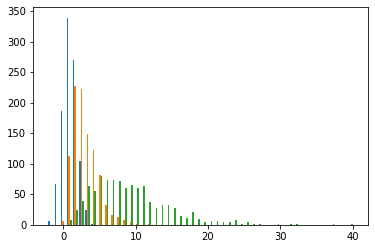

In [58]:
trace = np.array([
    np.random.normal(1, 1, 1000), 
    np.random.gamma(3, 1, 1000), 
    np.random.gamma(3, 3, 1000)
]).T

plt.hist(trace, bins=50)
plt.show()

Constraints are _holonomic_, meaning that they take the form $h(\theta_1, ..., \theta_n)=0$. Here, we have two constraints on the problem, namely,

$$\theta_1 - \theta_2 = 0$$

$$\theta_2 - \theta_3 - 1 = 0$$

These can be interpeted to mean that the first two parameters ought to be equal in expectation, and that the last two parameters ought to differ by 1. Below is a visualization of the posterior distrubutions of these constraints.

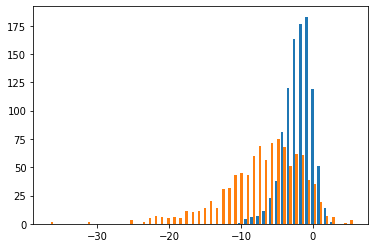

In [59]:
constraint = np.array([
    trace[:,0] - trace[:, 1], 
    trace[:,1] - trace[:, 2] - 1
]).T

plt.hist(constraint, bins=50)
plt.show()

Since they are holonomic, we need to find lagrange multipliers $\lambda$ that make transform each of these distributions to have a mean of 0. To do that, we use the ME() function, which takes the constraint trace as an argument, along with a tolerance $\epsilon$, an optimization rate $\eta$, and the max number of descent iterations to reach tolerance.  

### Results

The algorithm implementation gives a running trace of the optimization state. The first state variable is the iteration, the second is the magnitude of the lagrange multiplier vector $|\lambda|$, and the third is the magnitude of the gradient of the objective function $|E[ \nabla_\lambda e^{\lambda \cdot h(\theta)}]|$ which indicates how close the corrected constraint distributions are to satisfying the holonomic property. A gradient of $|E[ \nabla_\lambda e^{\lambda \cdot h(\theta)}]| = 0$ means the constraints are satisfied.

In [65]:
lambda_, weights, gradient = ME(constraint)

iter 0 |lambda| = 0.0 |grad| = 7.378330333 
iter 4 |lambda| = 9.672894 |grad| = 0.436473505 
iter 55 |lambda| = 5.841774 |grad| = 0.042928788 
iter 107 |lambda| = 4.872367 |grad| = 0.004117337 
iter 149 |lambda| = 4.803121 |grad| = 0.000399157 
iter 190 |lambda| = 4.796576 |grad| = 3.9333e-05 
iter 231 |lambda| = 4.795932 |grad| = 3.861e-06 
iter 255 |lambda| = 4.79588 |grad| = 9.92e-07 


#### Lagrange Multipliers
The algorithm outputs three variables. The first is the multipliers $\lambda$, the second are the correction weights, and the third is the value of the objective function. For this problem, $\lambda$ is given below,

In [64]:
lambda_

array([3.12010749, 3.64216906])

#### Weights

The weights can be used to calculate constrained posterior expectations. Given an unconstrained posterior trace of size $S$, $\{\theta_s\} \sim p(\theta|y)$, some expectation of interest, say $E_{\text{new}}[g(\theta)]$, can be approximated by 

$$ E_{\text{new}}[g(\theta)] = \frac{\int g(\theta) p(\theta | y) e^{\lambda \cdot h(\theta)} d\theta}{\int p(\theta | y) e^{\lambda \cdot h(\theta)} d\theta} \approx \frac{\sum_{s=1}^S g(\theta_s) e^{\lambda \cdot h(\theta_s)}}{\sum_{s=1}^S e^{\lambda \cdot h(\theta_s)}}$$

which is simply a weighted average of $g(\theta_s)$ with weights given by 

$$ w_s = \frac{e^{\lambda \cdot h(\theta_s)}}{\sum_{s=1}^S e^{\lambda \cdot h(\theta_s)}}$$

Therefore, the expectation can be approximated by 

$$ E_{\text{new}}[g(\theta)] = \sum_{s=1}^S w_s g(\theta_s) $$

#### Demonstration of Effectiveness

Using these weights, we can demonstrate that the algorithm is effective in performing the ME correction. The original posterior expections of the parameters are given below. Notice how the constraints are not satisfied; the first two parmeters are not equal in expectation, and the second two do not differ by 1 in expectation.

In [72]:
trace.mean(axis=0)

array([1.00619101, 2.98245659, 9.09119296])

Below are the constrained posterior expectations of the analysis. As you can see, the constrained expectations satisfy the holonomic constraints. The first two parameters are equal in expection, and the second two parameters differ by 1 in expectation. 

In [75]:
(trace * weights.reshape(-1,1)).sum(axis=0)

array([2.6416688 , 2.64166819, 1.6416674 ])